In [162]:
import numpy as np 
import gymnasium as gym 
import matplotlib.pyplot as plt
from collections import defaultdict
import random

In [163]:
env = gym.make('CliffWalking-v0', is_slippery=False)

In [164]:
def epsilon_greedy_policy(env, state, Q, epsilon):
    if np.random.uniform(0, 1) < epsilon:
        n_actions = env.action_space.n
        return np.random.choice(n_actions)  # Explore
    else:
        best_actions = np.where(Q[state,:] == np.max(Q[state,:]))[0]
        return random.choice(best_actions)    # Exploit

In [165]:
# Parameters
alpha = 0.1        # Learning rate
gamma = 1       # Discount factor
epsilon = 0.4      # Epsilon for epsilon-greedy
episodes = 50000    # Number of episodes
max_steps = 1000    # Max steps per episode

In [166]:
def q_learning_off_policy_td(env, alpha, gamma, epsilon, episodes, max_steps):

    # Initialize Q-table
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    Q = np.zeros((n_states, n_actions))
    collected_rewards = np.zeros(episodes)

    for episode in range(episodes):
        state = env.reset()[0]  # Initialize state
        
        for step in range(max_steps):
            # Choose action using epsilon-greedy policy
            action = epsilon_greedy_policy(env, state, Q, epsilon)
            
            # Take action, observe reward and next state
            next_state, reward, done, _, _ = env.step(action)
            collected_rewards[episode] += reward
            
            # Update Q-table
            best_next_action = np.argmax(Q[next_state, :])
            Q[state, action] += alpha * (reward + gamma * Q[next_state, best_next_action] - Q[state, action])
            
            # Transition to the next state
            state = next_state
            
            # End episode if done
            if done:
                break
    
    return Q, collected_rewards

In [167]:
def sarsa_on_policy_td(env, alpha, gamma, epsilon, episodes, max_steps):

    # Initialize Q-table
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    Q = np.zeros((n_states, n_actions))
    collected_rewards = np.zeros(episodes)

    for episode in range(episodes):
        state = env.reset()[0]  # Initialize state
        action = epsilon_greedy_policy(env, state, Q, epsilon) #Choose fist action

        for _ in range(max_steps):
            # Take action, observe reward and next state
            next_state, reward, done, _, _ = env.step(action)
            collected_rewards[episode] += reward

            next_action = epsilon_greedy_policy(env, next_state, Q, epsilon) 
            # Update Q-table
            Q[state, action] += alpha * (reward + gamma * Q[next_state, next_action] - Q[state, action])
            
            # Transition to the next state
            state = next_state
            action = next_action
            
            # End episode if done
            if done:
                break
    
    return Q, collected_rewards

In [168]:
#Compute optimal policy
Q_qlearning, Q_learning_rewards = q_learning_off_policy_td(env, alpha, gamma, epsilon, episodes, max_steps)
optimal_policy_qlearning = np.argmax(Q_qlearning, axis=1).reshape((4, 12))

Q_sarsa, Sarsa_rewards = sarsa_on_policy_td(env, alpha, gamma, epsilon, episodes, max_steps)
optimal_policy_sarsa = np.argmax(Q_sarsa, axis=1).reshape((4, 12))

# Close environment
env.close()

In [178]:
def visualize_actionvalue_with_numbers(action_value):
    action_value= action_value.reshape((4,12,4))
    action_value = np.round(action_value, 2)
    n_rows, n_cols,n_dir = action_value.shape
    #print(n_rows,n_cols)

    fig, ax = plt.subplots(figsize=(n_cols, n_rows))
    ax.set_xlim(-0.5, n_cols - 0.5)
    ax.set_ylim(-0.5, n_rows - 0.5)
    ax.set_xticks(np.arange(-0.5, n_cols, 1))
    ax.set_yticks(np.arange(-0.5, n_rows, 1))
    ax.grid(True)

    for i in range(n_rows):
        for j in range(n_cols):
            ax.text(j, i - 0.2, f"{action_value[i, j, 0]}", ha='center', va='center', fontsize=7, color="red")  # North
            ax.text(j, i + 0.2, f"{action_value[i, j, 2]}", ha='center', va='center', fontsize=7, color="green")  # South
            ax.text(j - 0.2, i, f"{action_value[i, j, 3]}", ha='center', va='center', fontsize=7, color="blue")  # West
            ax.text(j + 0.2, i, f"{action_value[i, j, 1]}", ha='center', va='center', fontsize=7, color="orange")  # East

    # Reverse the y-axis to align with matrix indexing
    ax.invert_yaxis()
    plt.title("Policy Visualization with Numbers")
    plt.show()

def visualize_policy(policy, name):
    n_rows, n_cols = policy.shape

    fig, ax = plt.subplots(figsize=(n_cols, n_rows))
    ax.set_xlim(-0.5, n_cols - 0.5)
    ax.set_ylim(-0.5, n_rows - 0.5)
    ax.set_xticks(np.arange(-0.5, n_cols, 1))
    ax.set_yticks(np.arange(-0.5, n_rows, 1))
    ax.grid(True)
    
    # Arrow parameters
    arrow_params = {
        "head_width": 0.2,
        "head_length": 0.2,
        "length_includes_head": True,
        "color": "blue",
    }
    
    for i in range(n_rows):
        for j in range(n_cols):
            if i != n_rows-1 or (i,j) == (n_rows-1,0):
                # Check each direction
                if policy[i, j] == 0:  # North
                    ax.arrow(j, i, 0, -0.4, **arrow_params)
                if policy[i, j] == 2:  # South
                    ax.arrow(j, i, 0, 0.4, **arrow_params)
                if policy[i, j] == 3:  # West
                    ax.arrow(j, i, -0.4, 0, **arrow_params)
                if policy[i, j] == 1:  # East
                    ax.arrow(j, i, 0.4, 0, **arrow_params)
        
    # Reverse the y-axis to align with matrix indexing
    ax.invert_yaxis()
    ax.set_xticklabels([])  # Remove x-axis tick labels
    ax.set_yticklabels([])  # Remove y-axis tick labels
    plt.title(f"Optimal Policy Visualization of {name}")
    plt.show()

def plot_cummulative_rewards(rewards, name):
    plt.plot(np.arange(1, 501), np.cumsum(rewards[:500]))
    plt.ylabel("Cummulative reward")
    plt.xlabel("Episodes")
    plt.title(f"Cummulative reward of {name}")
    plt.show(block=True)

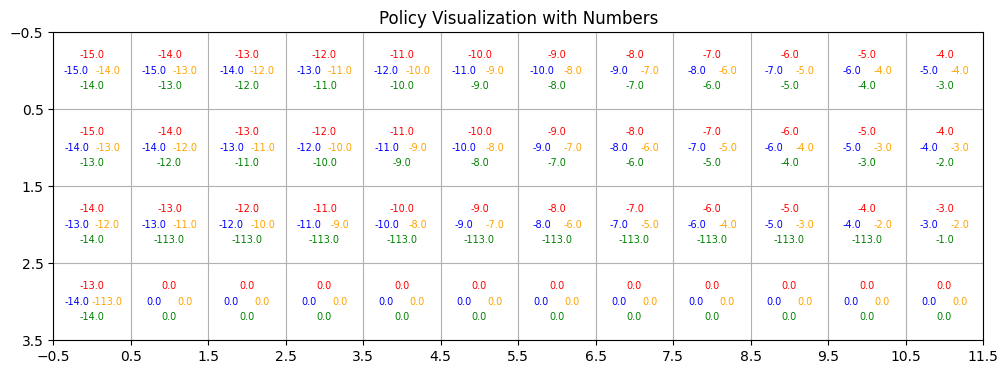

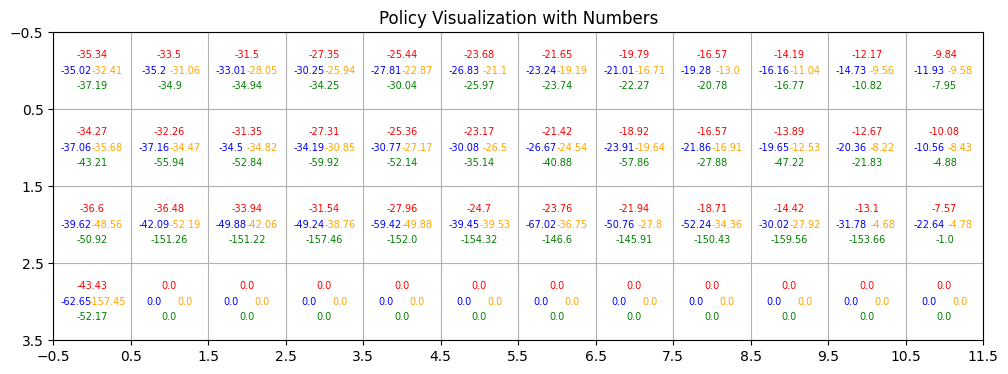

In [170]:
visualize_actionvalue_with_numbers(Q_qlearning)
visualize_actionvalue_with_numbers(Q_sarsa)

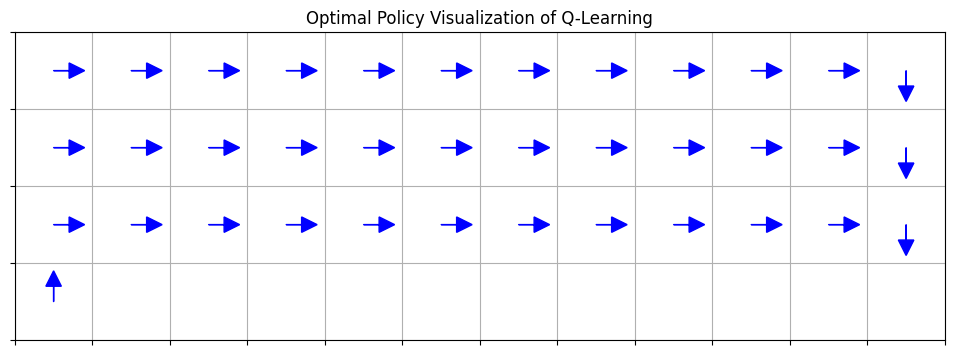

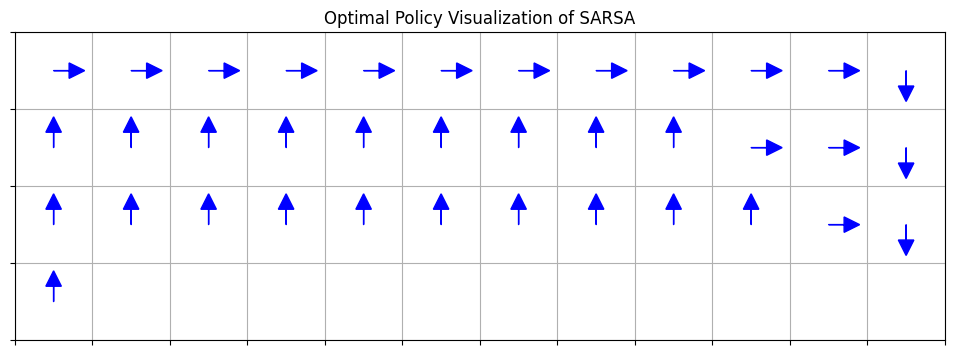

In [171]:
visualize_policy(optimal_policy_qlearning, name= "Q-Learning")
visualize_policy(optimal_policy_sarsa, name="SARSA")

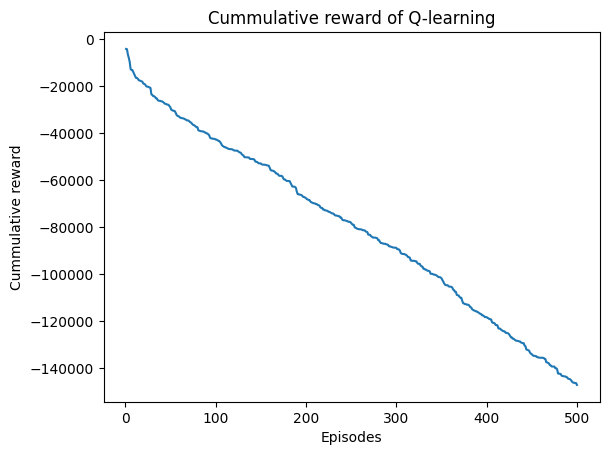

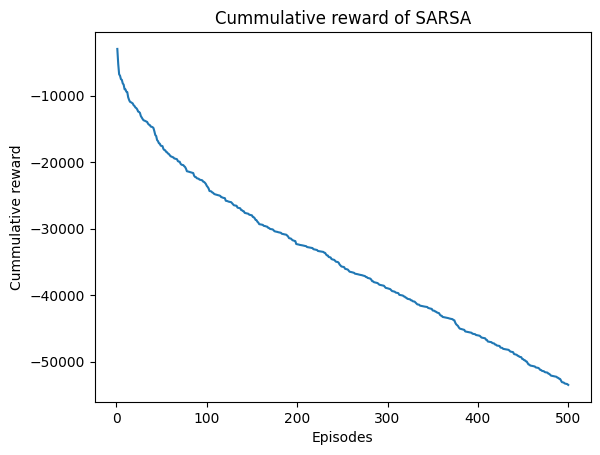

In [179]:
plot_cummulative_rewards(Q_learning_rewards, name= "Q-learning")
plot_cummulative_rewards(Sarsa_rewards, name= "SARSA")